In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm
sys.path.append('../../../src')

from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity
from common.default import PASSING_DEFAULT
from display.display import display
from individual_activity.individual_activity import IndividualActivity

In [2]:
seed = 64
np.random.seed(seed)

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'}
]

In [4]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = transform.homo[room_num][0]
    p_field = transform.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.54it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 20.60it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.62it/s]


# SVM
## 特徴量抽出とデータ生成

In [7]:
def extract_features(frame_num, label1, label2, individuals):
    if label1 not in individuals or label2 not in individuals:
        return None
    
    individual1 = individuals[label1]
    pos1 = individual1.get_indicator('position', frame_num)
    body1 = individual1.get_indicator('body_vector', frame_num)
    arm1 = individual1.get_indicator('arm_ext', frame_num)
    wrist1 = [
        individual1.get_keypoints('LWrist', frame_num),
        individual1.get_keypoints('RWrist', frame_num)
    ]
    if pos1 is None or body1 is None or arm1 is None or None in wrist1:
        return None
    
    individual2 = individuals[label2]
    pos2 = individual2.get_indicator('position', frame_num)
    body2 = individual2.get_indicator('body_vector', frame_num)
    arm2 = individual2.get_indicator('arm_ext', frame_num)
    wrist2 = [
        individual2.get_keypoints('LWrist', frame_num),
        individual2.get_keypoints('RWrist', frame_num)
    ]
    if pos2 is None or body2 is None or arm2 is None or None in wrist2:
        return None
    
    # ポジション間の距離
    norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
    if norm < 50 or 300 < norm:
        # norm が範囲外の時はデータに加えない
        # plot.ipynb の分布から決定した
        return None
    
    distance_prob = gauss(
        norm,
        mu=PASSING_DEFAULT['gauss_mu'],
        sigma=PASSING_DEFAULT['gauss_sig'])
    
    # 体の向き
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)
    p1p2 = pos2 - pos1
    p2p1 = pos1 - pos2
    p1_sim = cos_similarity(body1, p1p2)
    p2_sim = cos_similarity(body2, p2p1)
    body_direction = (np.average([p1_sim, p2_sim]) + 1) / 2  # [-1, 1] -> [0, 1]
    
    # 腕の上げ下げ
    arm_ave = np.average([arm1, arm2])
    
    # 手首の距離
    min_norm = np.inf
    for i in range(2):
        for j in range(2):
            norm = np.linalg.norm(
                np.array(wrist1[i]) - np.array(wrist2[j]), ord=2)
            if norm < min_norm:
                min_norm = norm
    distance_prob_wrist = gauss(
        min_norm,
        mu=PASSING_DEFAULT['wrist_gauss_mu'],
        sigma=PASSING_DEFAULT['wrist_gauss_sig'])

    return [distance_prob, body_direction, arm_ave, distance_prob_wrist]
    # return [distance_prob, body_direction, arm_ave]

columns = ['distance', 'body direction', 'arm average', 'wrist distance']
# columns = ['distance', 'body direction', 'arm average']

In [8]:
x_dict = {}
y_dict = {}
for setting in data_settings:
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    dirs = sorted(glob.glob(f'{common.data_dir}/{room_num}/{date}/{opt}/*'))
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]

    for path in dirs:
        file_num = common.split_path(path)[-1]
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in tqdm(csv_data, desc=f'{room_num}, {date}, {file_num}'):
            frame_num = row[0]
            label1 = f'{room_num}_{file_num}_{row[1]}'
            label2 = f'{room_num}_{file_num}_{row[2]}'

            features = extract_features(frame_num, label1, label2, individuals)
            key = f'{room_num}_{file_num}_{row[1]}_{row[2]}'

            if key not in x_dict:
                x_dict[key] = []
                y_dict[key] = []

            if features is not None:
                x_dict[key].append(features)
                y_dict[key].append(row[3])

09, 20210706, 09: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2833/2833 [00:00<00:00, 18131.23it/s]


## 分布をプロット

In [9]:
# %matplotlib widget

def plot_feature(x_train, y_train):
    x_true = np.array(x_train)[np.where(np.array(y_train) == 1)].T
    x_false = np.array(x_train)[np.where(np.array(y_train) == 0)].T

    # 分布をプロット
    def set_ax(ax, column_i, column_j, title):
        ax.set_title(title)
        ax.set_xlabel(column_i)
        ax.set_ylabel(column_j)
        if 'similarity' in column_i:
            ax.set_xlim((-1, 1))
        else:
            ax.set_xlim((0, 1))

        if 'similarity' in column_j:
            ax.set_ylim((-1, 1))
        else:
            ax.set_ylim((0, 1))

    n = int(len(columns) * (len(columns) - 1) / 2)  # 組み合わせ: len(columns) C 2

    fig = plt.figure(figsize=(12, n * 6))
    ax_count = 1
    for i in range(len(columns) - 1):
        for j in range(i + 1, len(columns)):
            ax = fig.add_subplot(n, 2, ax_count * 2 - 1)
            ax.scatter(x_false[i], x_false[j])
            set_ax(ax, columns[i], columns[j], 'false data')

            ax = fig.add_subplot(n, 2, ax_count * 2)
            ax.scatter(x_true[i], x_true[j], color='red')
            set_ax(ax, columns[i], columns[j], 'true data')

            ax_count += 1
    
    # fig = plt.figure(figsize=(12, 12))
    # ax = fig.add_subplot(111, projection="3d")
    # ax.scatter(x_false[0], x_false[1], x_false[2], marker='.')
    # ax.scatter(x_true[0], x_true[1], x_true[2], color='red', marker='.')
    # ax.set_xlabel('distance')
    # ax.set_xlim((0, 1))
    # ax.set_ylabel('body similarity')
    # ax.set_ylim((-1, 1))
    # ax.set_zlabel('arm average')
    # ax.set_zlim((0, 1))

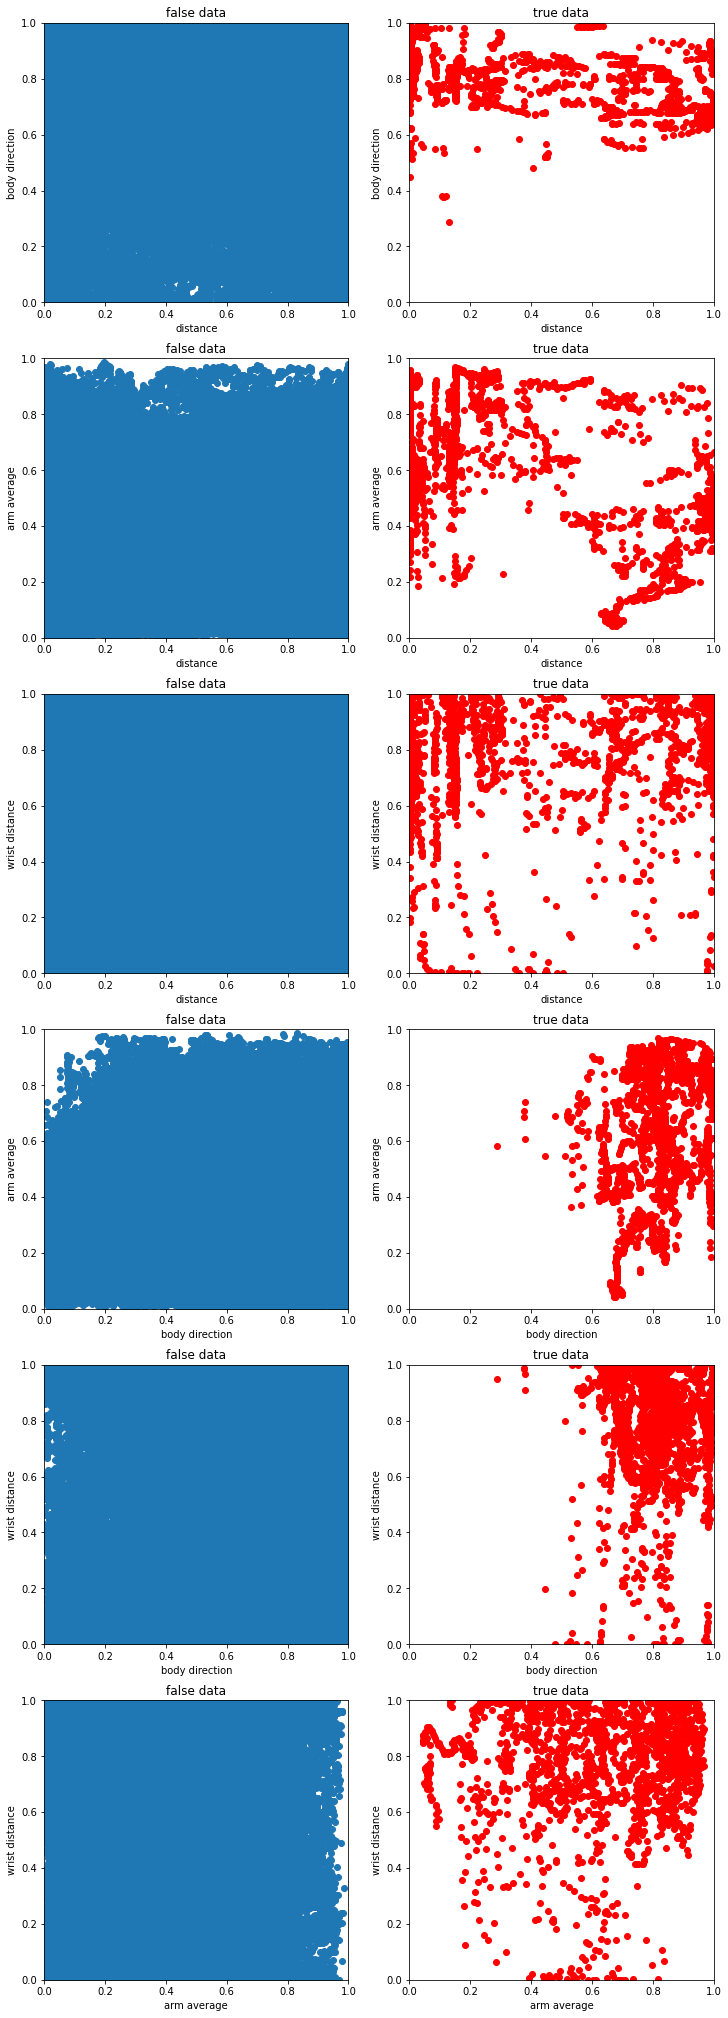

In [10]:
# データを整形
x_lst = []
y_lst = []
for x, y in zip(x_dict.values(), y_dict.values()):
    x_lst += x
    y_lst += y
plot_feature(x_lst, y_lst)

## 学習・検証

In [11]:
from sklearn.svm import SVC

from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# import seaborn as sns
import pickle

## 模擬実験のモデルで検証

## データセット作成

In [12]:
train_ratio = 0.7
random_keys = np.random.choice(
    list(x_dict.keys()),
    size=len(x_dict),
    replace=False
)
train_len = int(len(x_dict) * train_ratio)
train_keys = random_keys[:train_len]
test_keys = random_keys[train_len:]

x_train_dict = {key: x_dict[key] for key in train_keys}
y_train_dict = {key: y_dict[key] for key in train_keys}
x_train = []
y_train = []
for x, y in zip(x_train_dict.values(), y_train_dict.values()):
    x_train += x
    y_train += y

x_test_dict = {key: x_dict[key] for key in test_keys}
y_test_dict = {key: y_dict[key] for key in test_keys}
x_test = []
y_test = []
for x, y in zip(x_test_dict.values(), y_test_dict.values()):
    x_test += x
    y_test += y

# x_train = scale(x_train)

In [13]:
len_pass = len([i for i in y_lst if i == 1])
len_not_pass = len([i for i in y_lst if i == 0])

print(f'all length:{len(y_lst)}')
print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

all length:281456
passing: 2012
not passing: 279444


In [14]:
len_pass_train = len([i for i in y_train if i == 1])
len_not_pass_train = len([i for i in y_train if i == 0])

print(f'train length:{len(y_train)}')
print(f'passing: {len_pass_train}')
print(f'not passing: {len_not_pass_train}')

train length:196810
passing: 1485
not passing: 195325


In [15]:
len_pass_test = len([i for i in y_test if i == 1])
len_not_pass_test = len([i for i in y_test if i == 0])

print(f'test length:{len(y_test)}')
print(f'passing: {len_pass_test}')
print(f'not passing: {len_not_pass_test}')

test length:84646
passing: 527
not passing: 84119


In [16]:
# パスかどうかの比率を合わせる
ratio = 1

x_train_new = []
y_train_new = []
for x, y in zip(x_train, y_train):
    if y == 1:
        x_train_new.append(x)
        y_train_new.append(y)
    else:
        # y == 0
        if np.random.random() <= (len_pass / len_not_pass) * ratio:
            # 確率で追加
            x_train_new.append(x)
            y_train_new.append(y)

len_pass_new = len([i for i in y_train_new if i == 1])
len_not_pass_new = len([i for i in y_train_new if i == 0])

print(f'train length:{len(y_train)}')
print(f'passing: {len_pass_new}')
print(f'not passing: {len_not_pass_new}')

train length:196810
passing: 1485
not passing: 1438


In [26]:
model = SVC(C=90, gamma=0.95)

model.fit(x_train_new, y_train_new)

SVC(C=90, gamma=0.95)

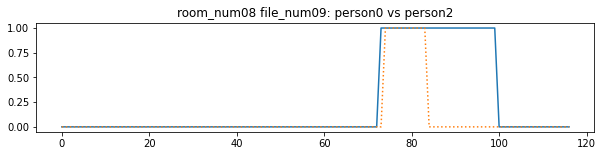

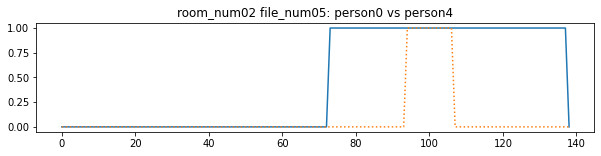

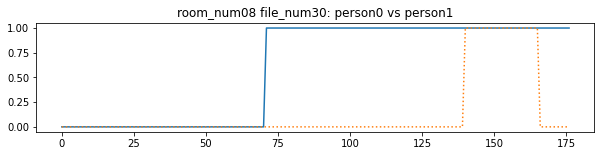

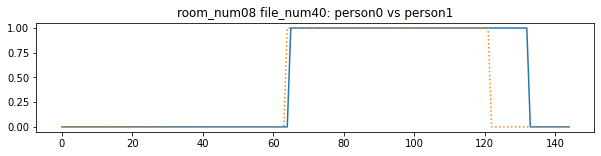

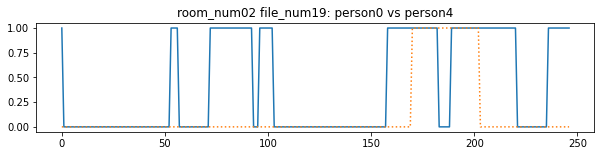

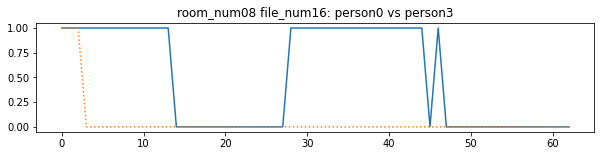

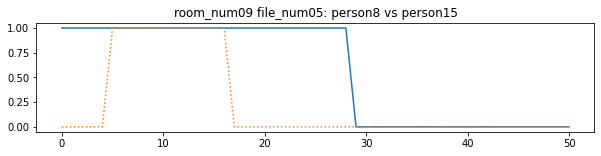

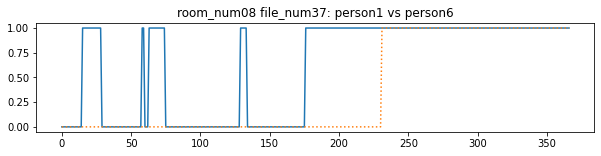

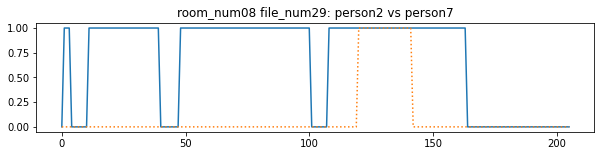

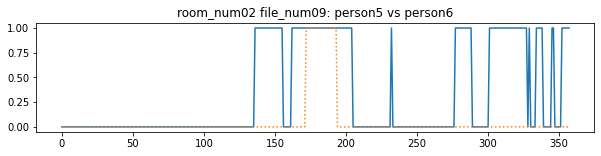

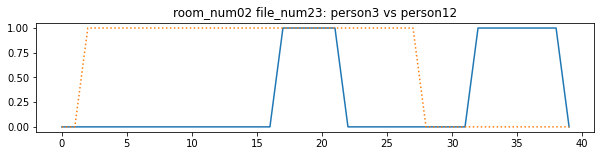

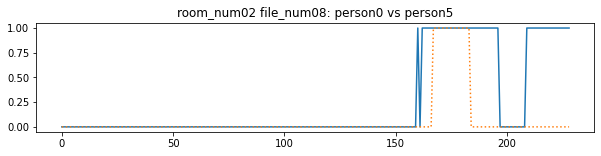

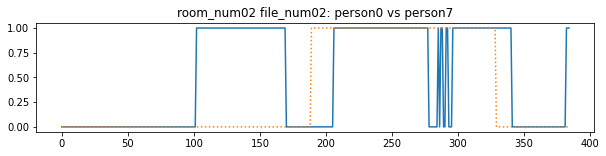

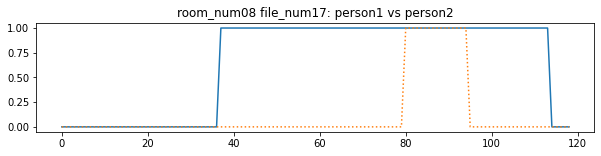

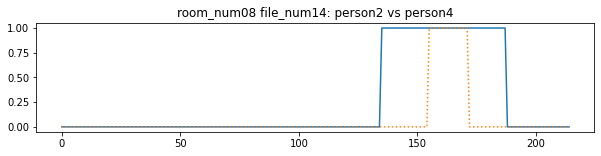

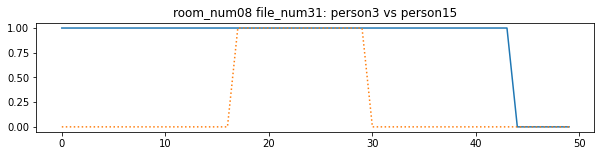

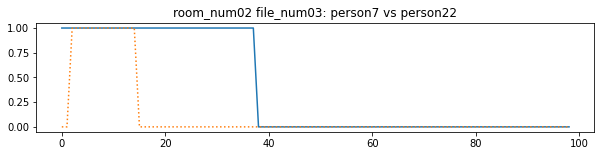

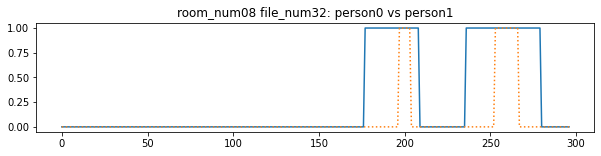

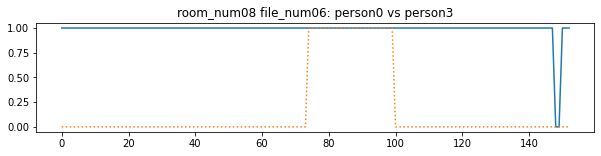

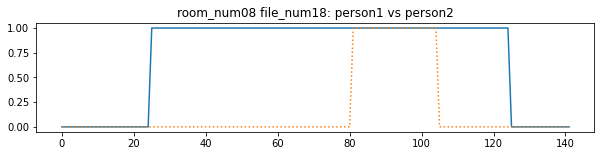

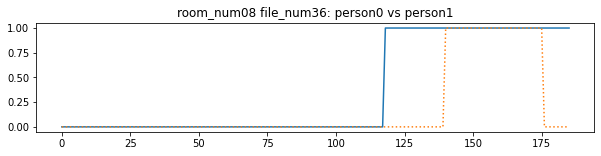

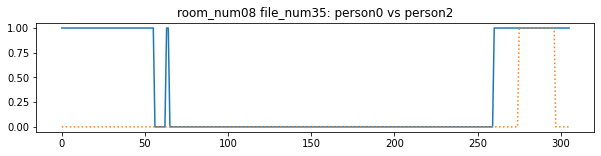

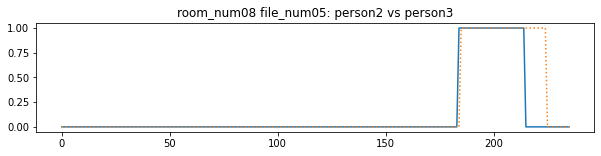

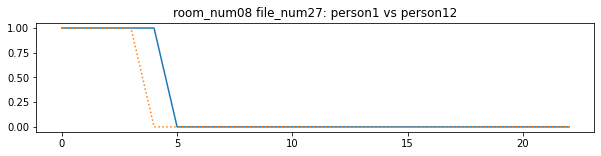

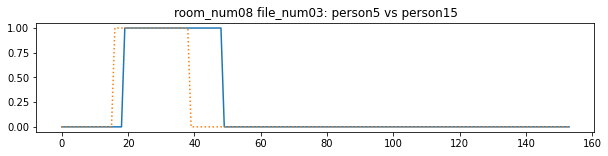

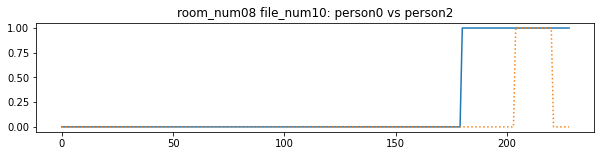

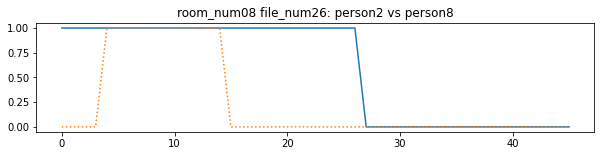

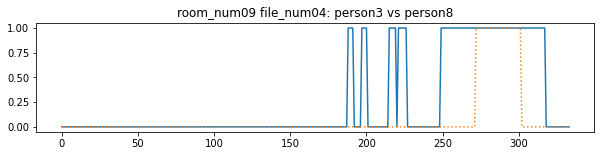

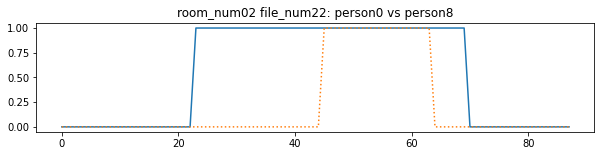

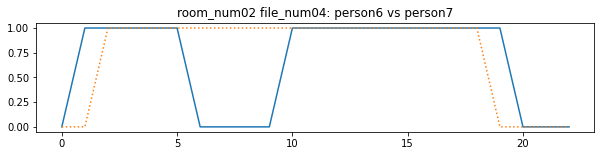

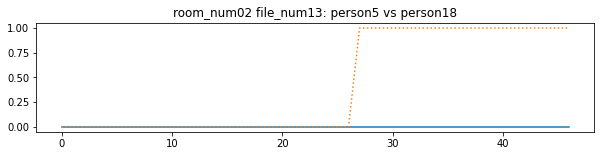

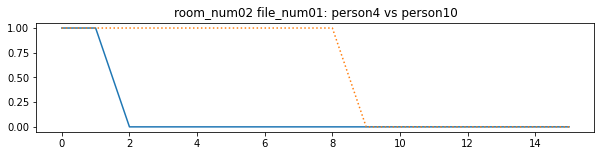

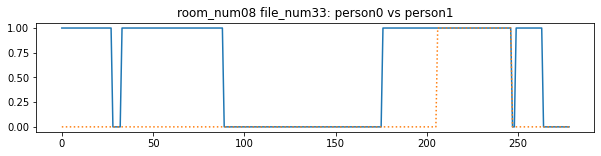

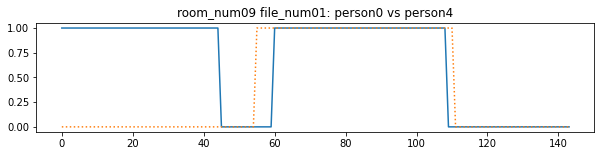

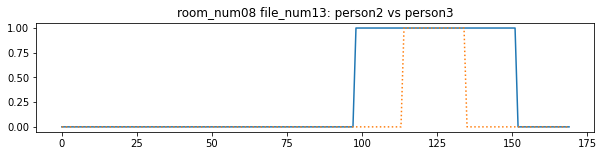

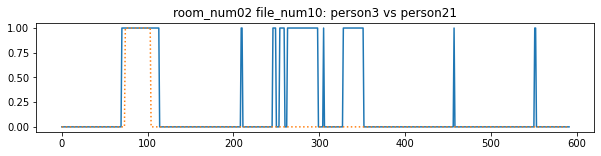

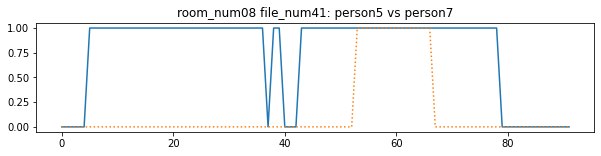

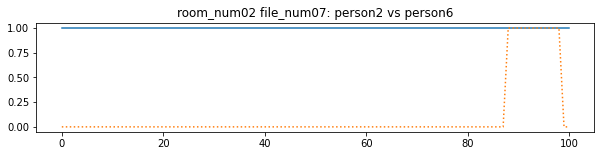

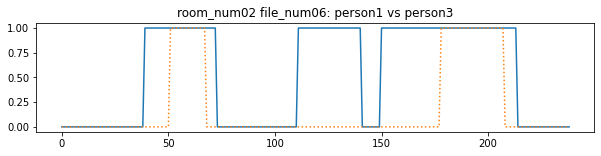

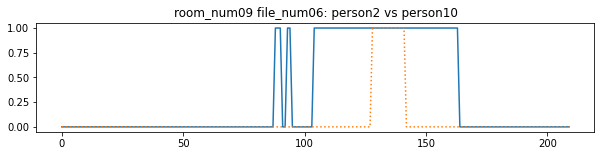

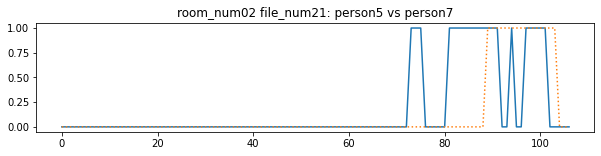

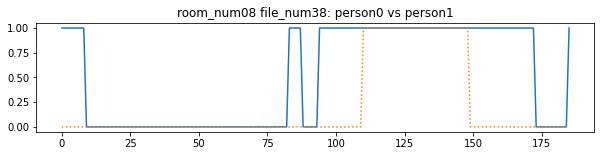

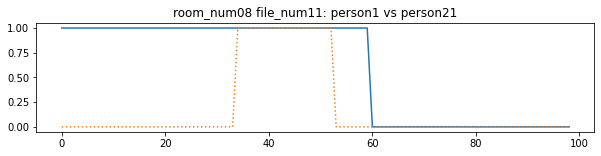

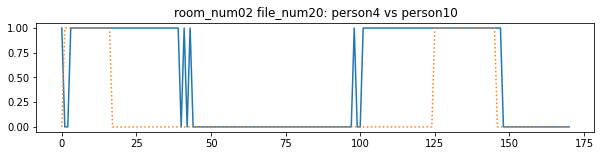

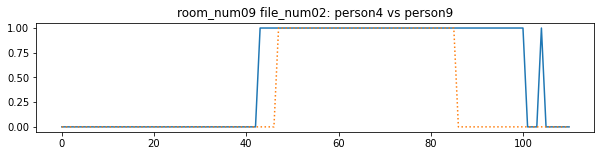

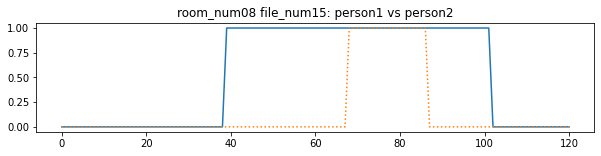

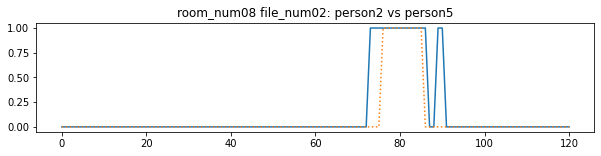

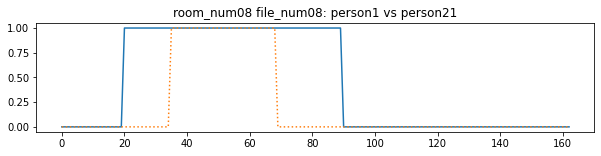

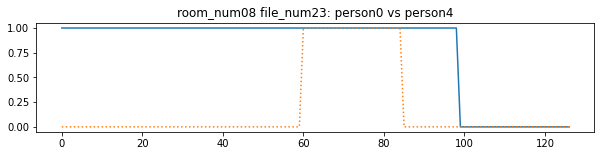

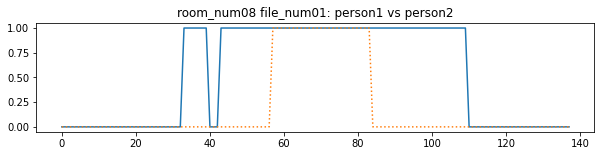

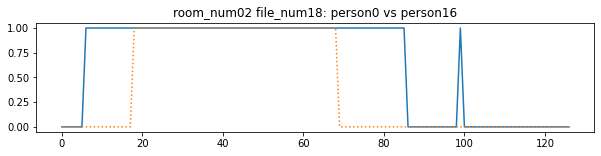

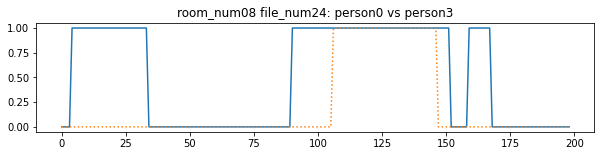

In [27]:
%matplotlib inline
for key, x, y in zip(x_train_dict.keys(), x_train_dict.values(), y_train_dict.values()):
    if len(x) == 0 or 1 not in y:
        continue

    pred = model.predict(x)
    plt.figure(figsize=(10, 2))
    plt.plot(pred)
    plt.plot(y, linestyle=':')
    plt.ylim((-0.05, 1.05))
    # plt.xlabel('frame')
    # plt.ylabel('passing')
    key = key.split('_')
    plt.title(f'room_num{key[0]} file_num{key[1]}: person{key[2]} vs person{key[3]}')
    plt.show()

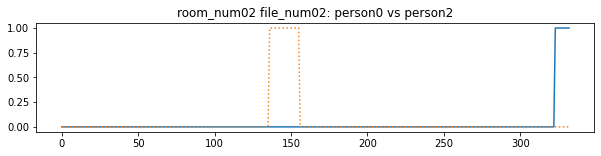

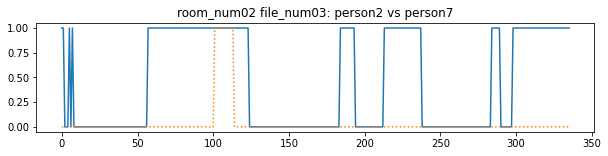

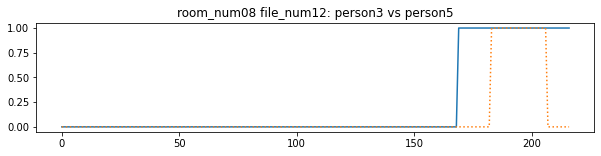

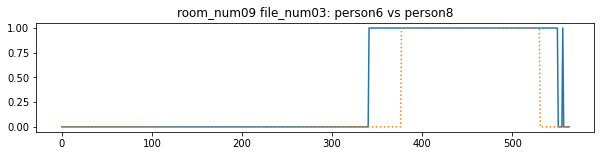

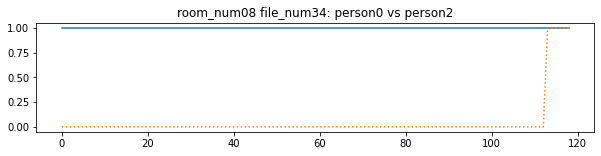

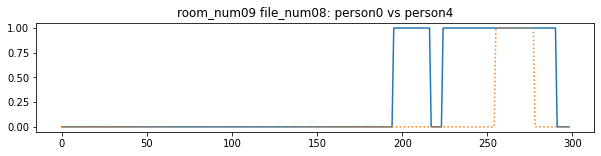

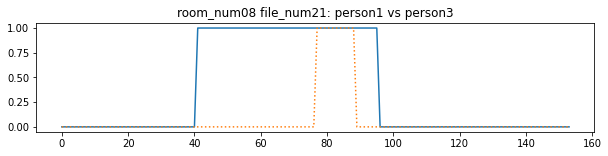

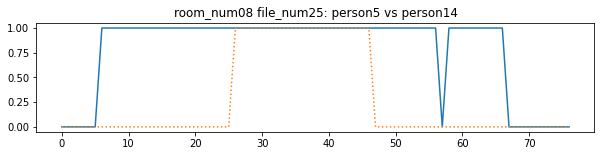

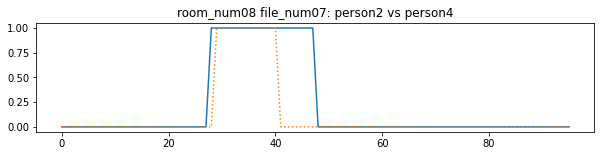

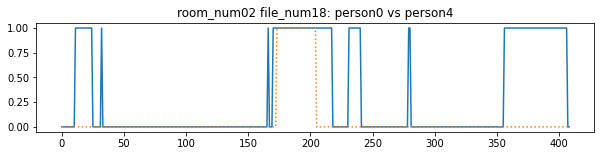

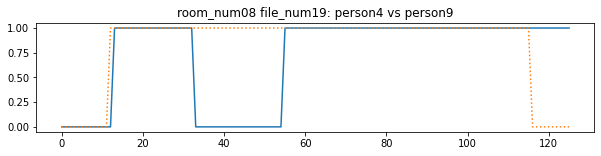

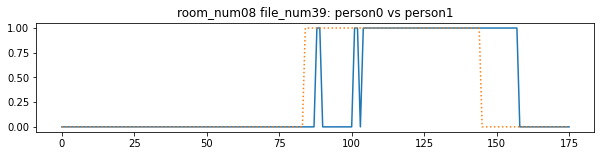

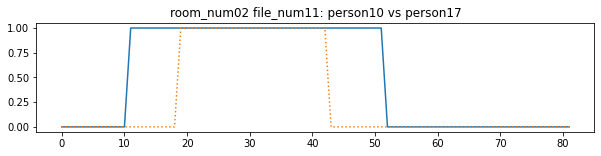

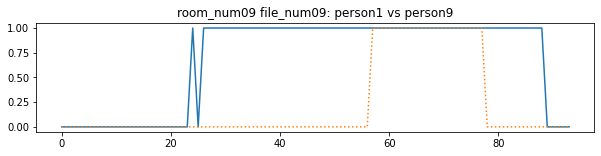

In [28]:
%matplotlib inline
for key, x, y in zip(x_test_dict.keys(), x_test_dict.values(), y_test_dict.values()):
    if len(x) == 0 or 1 not in y:
        continue

    pred = model.predict(x)
    plt.figure(figsize=(10, 2))
    plt.plot(pred)
    plt.plot(y, linestyle=':')
    plt.ylim((-0.05, 1.05))
    # plt.xlabel('frame')
    # plt.ylabel('passing')
    key = key.split('_')
    plt.title(f'room_num{key[0]} file_num{key[1]}: person{key[2]} vs person{key[3]}')
    plt.show()

In [29]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

In [30]:
%matplotlib inline
print('accuracy: {:.3f}'.format(accuracy_score(y_train, pred_train)))
print('precision: {:.3f}'.format(precision_score(y_train, pred_train)))
print('recall: {:.3f}'.format(recall_score(y_train, pred_train)))
print('f1_score: {:.3f}'.format(f1_score(y_train, pred_train)))

# cm = confusion_matrix(y_train, pred_train)
# sns.heatmap(cm, cmap='Blues')

accuracy: 0.918
precision: 0.079
recall: 0.921
f1_score: 0.145


In [31]:
print('accuracy: {:.3f}'.format(accuracy_score(y_test, pred_test)))
print('precision: {:.3f}'.format(precision_score(y_test, pred_test)))
print('recall: {:.3f}'.format(recall_score(y_test, pred_test)))
print('f1_score: {:.3f}'.format(f1_score(y_test, pred_test)))

# cm = confusion_matrix(y_train, pred_test)
# sns.heatmap(cm, cmap='Blues')

accuracy: 0.904
precision: 0.055
recall: 0.888
f1_score: 0.103


# パラメータ調整

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, log_loss
from tqdm import tqdm

In [24]:
params = {
    'C': np.arange(90, 110, 1),
    'gamma': np.arange(0.95, 1.1, 0.01)
}

max_score = 0
min_score = np.inf
auc_param = {}
logloss_param = {}
for c in tqdm(params['C']):
    for gamma in params['gamma']:
        model = SVC(C=c, gamma=gamma)
        model.fit(x_train_new, y_train_new)
        pred = model.predict(x_test)
        
        score = roc_auc_score(pred, y_test)
        if score > max_score:
            max_score = score
            auc_param = {'C': c, 'gamma': gamma}
            
        score = log_loss(pred, y_test)
        if score < min_score:
            min_score = score
            logloss_param = {'C': c, 'gamma': gamma}
            
print('max auc score: {}, C: {}, gamma: {}'.format(max_score, auc_param['C'], auc_param['gamma']))
print('min logloss score: {}, C: {}, gamma: {}'.format(min_score, logloss_param['C'], logloss_param['gamma']))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [15:34<00:00, 46.71s/it]

max auc score: 0.5270740450184987, C: 90, gamma: 0.95
min logloss score: 3.310004031989271, C: 90, gamma: 0.95


## モデルを保存

In [25]:
model_path = os.path.join(common.model_dir, 'pass_model_svm.pickle')
with open(model_path, mode='wb') as f:
    pickle.dump(model, f)